In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc
import matplotlib.pyplot as plt

import os
import h5py

from BalleHP import BalleHP
from read_data import read_data_numpy

2023-03-06 14:25:01.672017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 14:25:01.816909: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 14:25:02.373740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/data/miniconda3/envs/tf2/lib/
2023-03-06 14:25:02.373832: W tensorflow/co

## General Settings

In [2]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [3]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 14

In [4]:
tf.config.set_visible_devices([], 'GPU')

2023-03-06 14:25:10.662903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 14:25:10.664341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 14:25:10.673380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 14:25:10.674622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 14:25:10.675814: I tensorflow/compiler/xla/stream_executo

## Functions

In [5]:
def get_model_files(folder, name):
    files  = os.listdir(folder)
    files  = [f for f in files if name in f]
    models = [f for f in files if "model" in f]
    losses = [f for f in files if "losses" in f]
    return models, losses

In [6]:

def show_image_comparison(img, reco, id, format):
    """Visualize the original image and the reconstructed image side by side."""
    if format=='channels_first':
        img  = np.transpose(img, (1, 2, 0))
        reco = np.transpose(reco, (1, 2, 0))
    
    # check if the images are normalized
    norm_img  = np.max(img)  <= 1.0
    norm_reco = np.max(reco) <= 1.0

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), constrained_layout=True)
    axes[0].imshow(img  if norm_img  else img.astype(np.uint8)) 
    axes[1].imshow(reco if norm_reco else reco.astype(np.uint8)) 
    
    axes[0].axis('off')
    axes[1].axis('off')
    
    fig.suptitle('Original image (left) and reconstructed image (right) (id: {})'.format(id))

    # Show the plot
    plt.show()

In [7]:
def select_random_images(data, n):
    """Selects n random images from the data."""
    idx = np.random.choice(data.shape[0], n, replace=False)
    return data[idx], idx

## Constants

In [8]:
DATA_FOLDER  = "../data/stl10/stl10_binary/"
DATA_FILE    = "unlabeled_X.bin"

CH_FORMAT = "channels_last"
EPOCHS    = 50
NORM      = "normFalse"
LAMBDA    = 0.5

MODEL_FOLDER = "../models/"

## Load Data

In [9]:
data_path = os.path.join(DATA_FOLDER, DATA_FILE)
data      = read_data_numpy(data_path, CH_FORMAT).astype('float32') 

if NORM == "normTrue":
    # normalize the data to [0,1]
    data = data / 255.0

## Choose the trained model

In [11]:
name = "hp_{}_epochs{}_{}_l{}".format(CH_FORMAT, EPOCHS, NORM, LAMBDA)

models, losses = get_model_files(MODEL_FOLDER, name)
print("Models: ", models)


model_path = os.path.join(MODEL_FOLDER, models[0])
loss_path  = os.path.join(MODEL_FOLDER, losses[0])

Models:  ['model_hp_channels_last_epochs50_normFalse_20230306112301.h5']


## Train/Test loss

In [12]:
# open the .h5 file containing the losses and load them as two numpy arrays train_loss and test_loss
with h5py.File(loss_path, 'r') as f: # type: ignore
    train_loss = np.array(f['train'])
    test_loss  = np.array(f['test'])

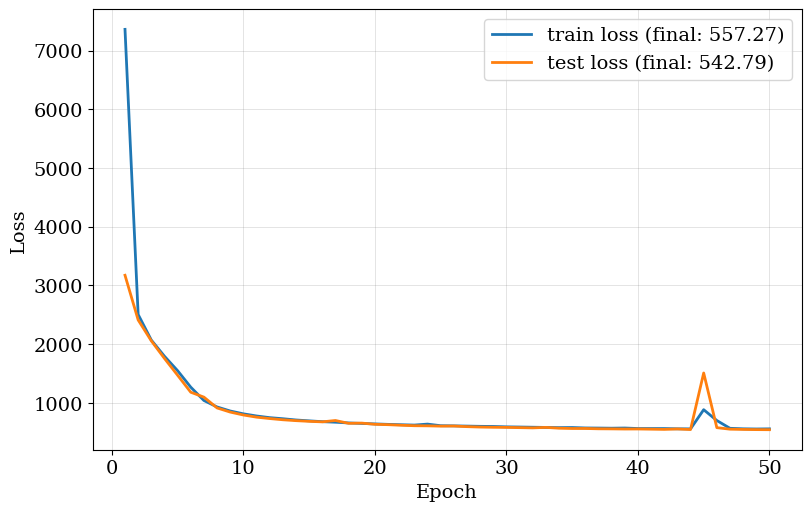

In [13]:
epochs = np.arange(1, len(train_loss)+1)


fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.grid(True, which='both', ls='-', lw=0.5, c='grey', alpha=0.3)

ax.plot(epochs, train_loss, lw=2, label=f"train loss (final: {train_loss[-1]:.2f})")
ax.plot(epochs, test_loss,  lw=2, label=f"test loss (final: {test_loss[-1]:.2f})")

ax.legend()

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# fig.savefig("./plots/hp_losses.png", dpi=300, facecolor="w")

plt.show()

## Image Reconstruction

In [14]:
vae = BalleHP(N=128, M=192, k1=3, k2=3, c=3, format=CH_FORMAT)

if CH_FORMAT == 'channels_first':
    x = tf.zeros((1, 3, 96, 96))
    
elif CH_FORMAT == 'channels_last':
    x = tf.zeros((1, 96, 96, 3))
else:
    raise ValueError("CH_FORMAT must be either 'channels_first' or 'channels_last'")

# call the model to create the weights
_ = vae(x)

# load the weights from the .h5 file
vae.load_weights(model_path)

2023-03-06 14:25:30.944101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
img, ids = select_random_images(data, 4)

img_reco, rate_recoi, rate_recob = vae(img) # type: ignore

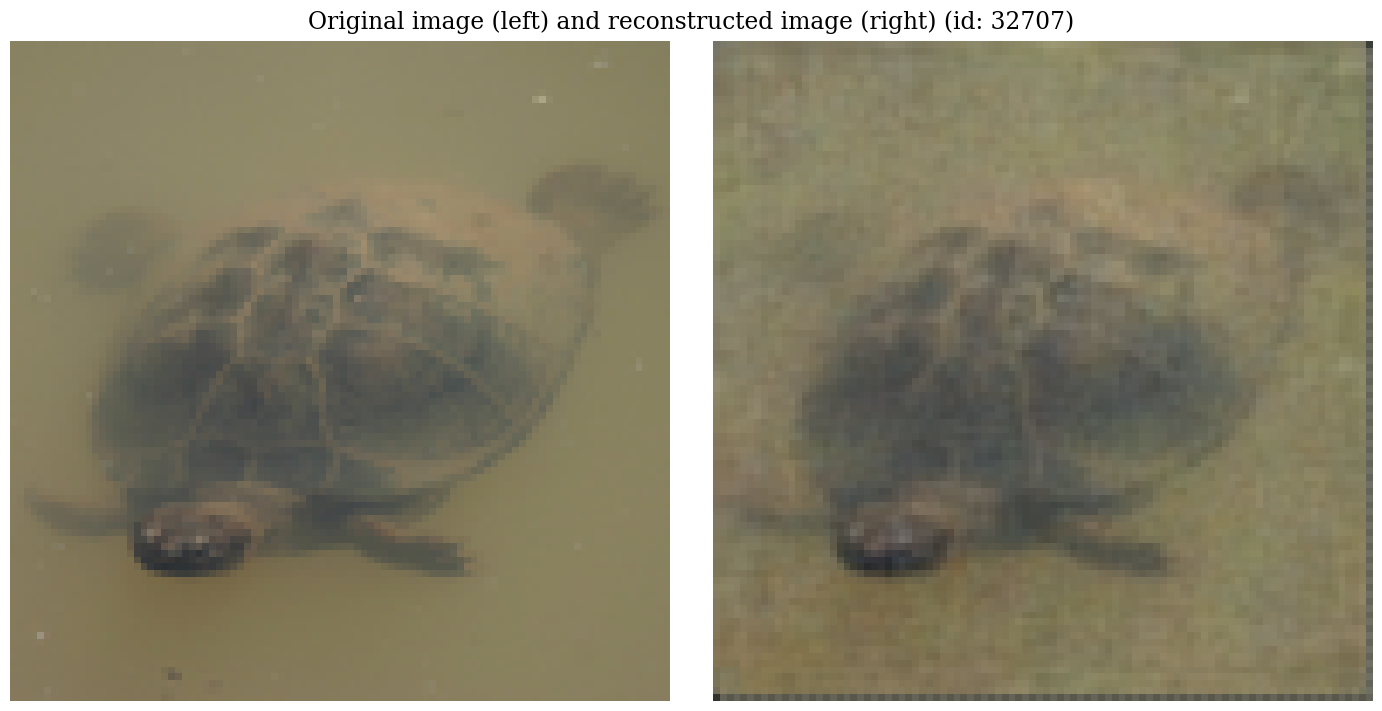

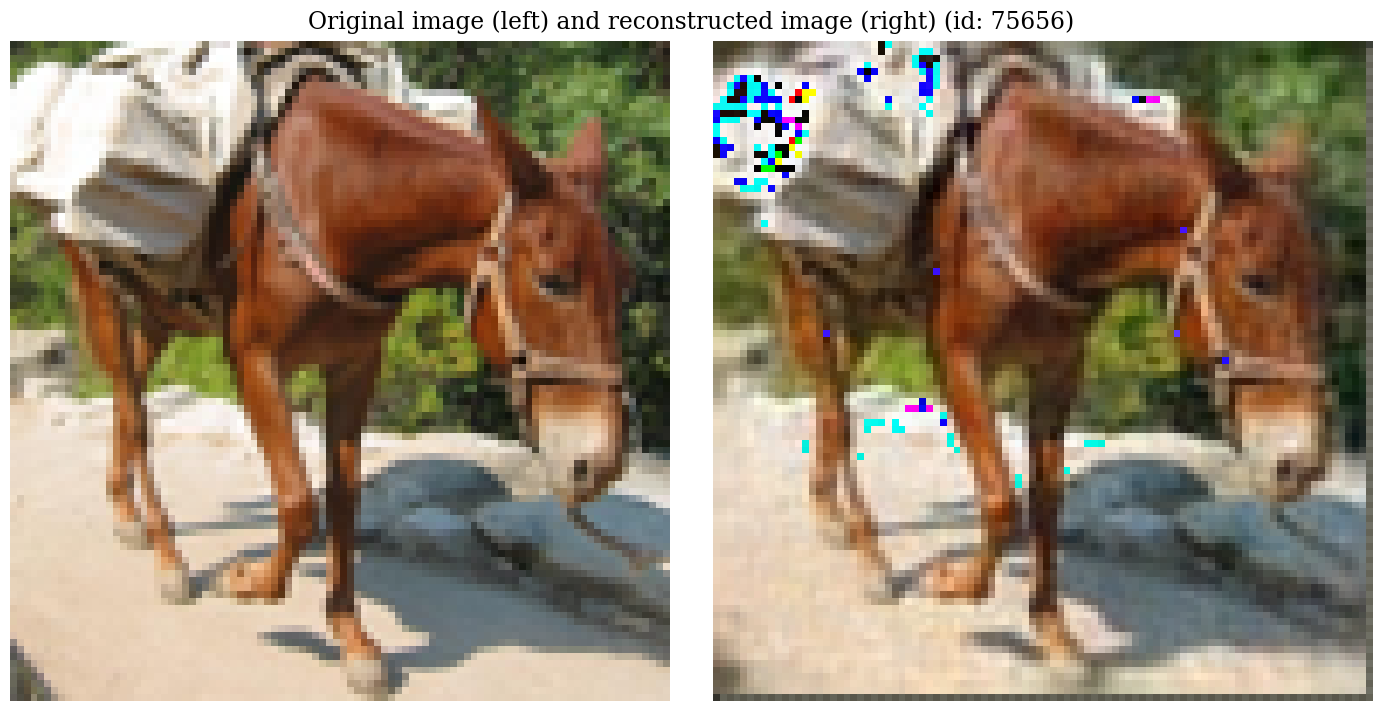

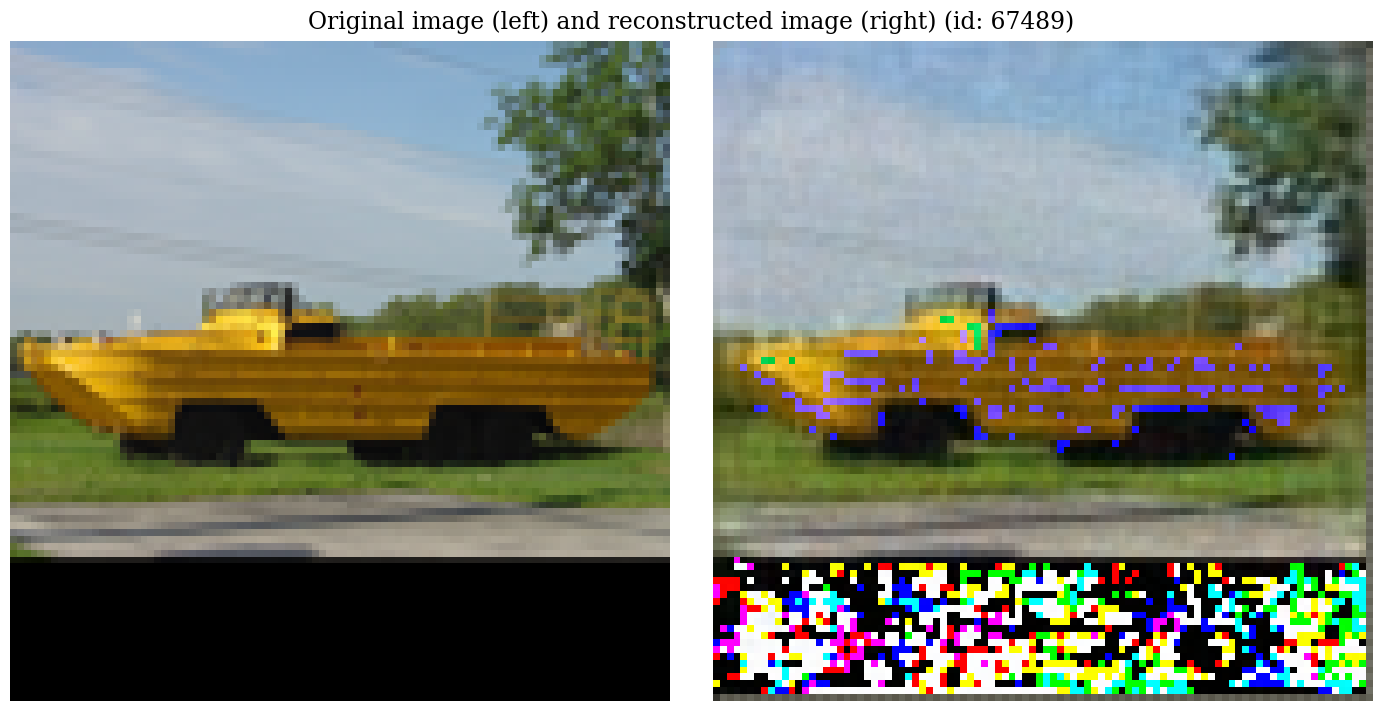

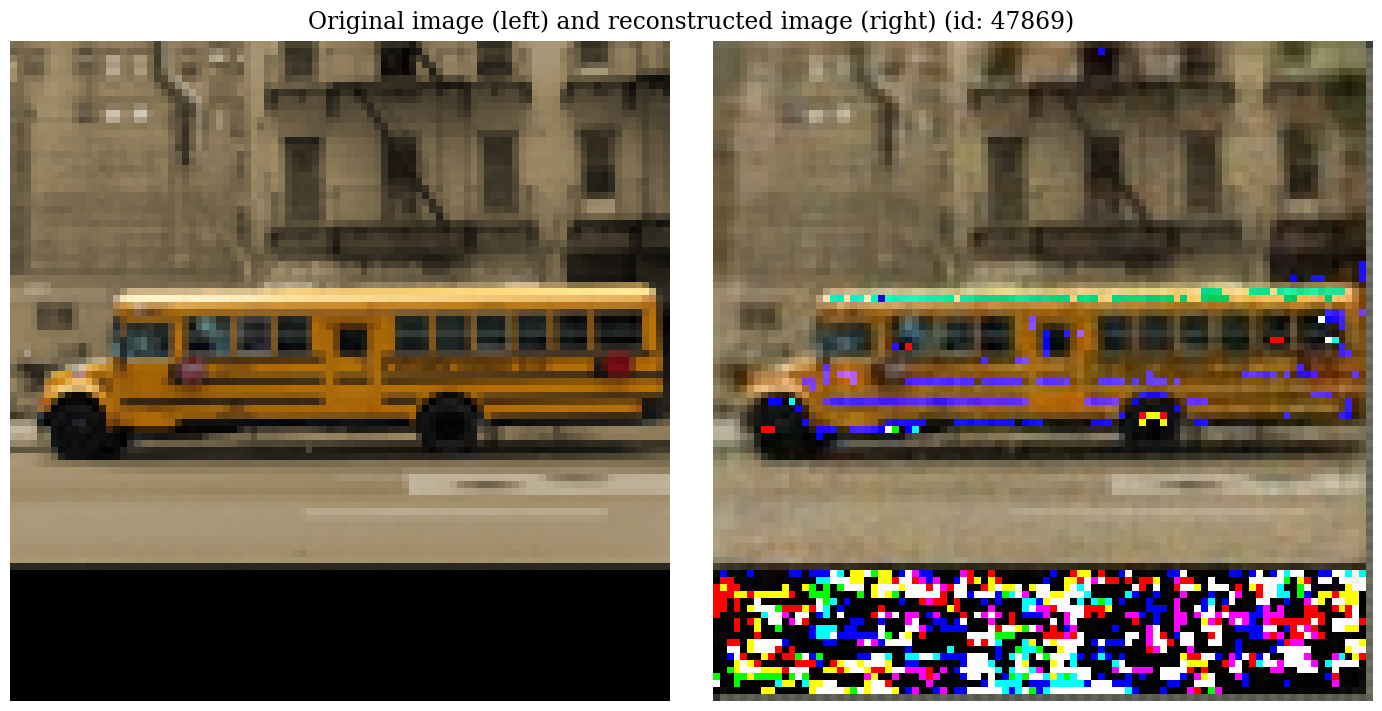

In [16]:
for i in range(img.shape[0]):
    show_image_comparison(img[i], img_reco[i], ids[i], CH_FORMAT)